# Leaf Classify
### Imports

In [84]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
from torchinfo import summary

from sklearn.metrics import classification_report, f1_score, roc_auc_score

import matplotlib.pyplot as plt

from tqdm import tqdm

import pandas as pd
import numpy as np

import math
from os import walk

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Auxiliary functions

In [86]:
def show_leaf(image,label):
    plt.imshow(image.permute(1,2,0))
    plt.title(f'class = {label}')
    plt.xticks([])
    plt.yticks([])

### Load the dataset

In [87]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = datasets.ImageFolder('./leaf_disease_dataset', transform=transform)

### Split into train test and val sets

In [88]:
generator = torch.Generator().manual_seed(42)

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=generator)

print("Length of the train set: " + str(len(train_dataset)))
print("Length of the test set: " + str(len(test_dataset)))
print("Length of the val set: " + str(len(val_dataset)))

Length of the train set: 15466
Length of the test set: 3314
Length of the val set: 3313


In [89]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

### Show an example image

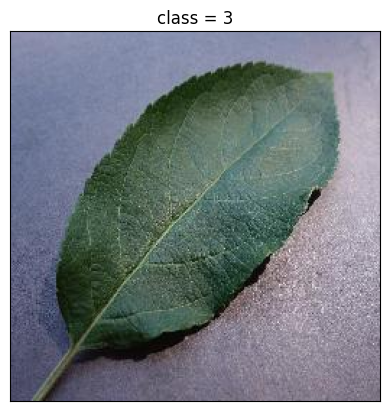

In [90]:
images, labels = next(iter(train_loader))

show_leaf(images[0],labels[0])

### Define a tradicional ML method

In [92]:
class LinearClassifier(nn.Module):
    def __init__(self,input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        z = self.linear(x)
        return z

In [97]:
input_dim = 3*256*256
output_dim = 38
lc = LinearClassifier(input_dim,output_dim)
summary(lc)

Layer (type:depth-idx)                   Param #
LinearClassifier                         --
├─Linear: 1-1                            7,471,142
Total params: 7,471,142
Trainable params: 7,471,142
Non-trainable params: 0

In [98]:
def train_linear_model(
    lc, 
    n_epochs,
    train_loader,
    val_loader,
    optimizer,
    criterion
):
    accuracies = []
    f1_scores = []

    lc.to(device)
    
    for epoch in tqdm(range(n_epochs)):
        #training
        for x_train,y_train in train_loader: 
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            z = lc(x_train.view(-1,256*256*3))
            loss = criterion(z,y_train)
            loss.backward()
            optimizer.step()

        all_labels = []
        all_preds = []
        correct = 0
        #evaluation
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                
                z_val = lc(x_val.view(-1,256*256*3))
                _,y_pred = torch.max(z_val.data,1)
                correct += (y_pred == y_val).sum().item()
                all_labels.extend(y_val.cpu().numpy())
                all_preds.extend(y_pred.cpu().numpy())

        accuracy = correct/len(val_loader.dataset)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Val Acc: {accuracy * 100:.2f}%, Val F1: {f1 * 100:.2f}%")
        accuracies.append(accuracy)
        f1_scores.append(f1)

    return accuracies, f1_scores

In [99]:
n_epochs = 50
lr = 1e-3
optimizer = torch.optim.Adam(lc.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

accuracies, f1_scores = train_linear_model(lc,n_epochs,train_loader,val_loader,optimizer,criterion)

  2%|▉                                           | 1/50 [00:20<17:02, 20.86s/it]

Val Acc: 24.60%, Val F1: 19.37%


  4%|█▊                                          | 2/50 [00:42<16:53, 21.12s/it]

Val Acc: 35.95%, Val F1: 30.48%


  6%|██▋                                         | 3/50 [01:02<16:25, 20.96s/it]

Val Acc: 30.21%, Val F1: 27.11%


  8%|███▌                                        | 4/50 [01:23<15:57, 20.82s/it]

Val Acc: 38.67%, Val F1: 34.78%


 10%|████▍                                       | 5/50 [01:44<15:33, 20.75s/it]

Val Acc: 32.84%, Val F1: 33.93%


 12%|█████▎                                      | 6/50 [02:04<15:13, 20.76s/it]

Val Acc: 36.95%, Val F1: 32.10%


 14%|██████▏                                     | 7/50 [02:25<14:49, 20.69s/it]

Val Acc: 36.70%, Val F1: 31.97%


 16%|███████                                     | 8/50 [02:46<14:28, 20.67s/it]

Val Acc: 39.75%, Val F1: 37.81%


 18%|███████▉                                    | 9/50 [03:07<14:15, 20.86s/it]

Val Acc: 40.81%, Val F1: 36.01%


 20%|████████▌                                  | 10/50 [03:28<14:00, 21.01s/it]

Val Acc: 30.15%, Val F1: 31.35%


 22%|█████████▍                                 | 11/50 [03:49<13:41, 21.07s/it]

Val Acc: 42.05%, Val F1: 38.36%


 24%|██████████▎                                | 12/50 [04:10<13:18, 21.02s/it]

Val Acc: 41.47%, Val F1: 38.22%


 26%|███████████▏                               | 13/50 [04:31<12:57, 21.00s/it]

Val Acc: 44.67%, Val F1: 41.87%


 28%|████████████                               | 14/50 [04:52<12:32, 20.91s/it]

Val Acc: 44.31%, Val F1: 42.94%


 30%|████████████▉                              | 15/50 [05:13<12:10, 20.86s/it]

Val Acc: 39.72%, Val F1: 37.65%


 32%|█████████████▊                             | 16/50 [05:33<11:47, 20.81s/it]

Val Acc: 42.14%, Val F1: 39.37%


 34%|██████████████▌                            | 17/50 [05:54<11:28, 20.85s/it]

Val Acc: 36.76%, Val F1: 35.34%


 36%|███████████████▍                           | 18/50 [06:15<11:07, 20.86s/it]

Val Acc: 36.79%, Val F1: 35.84%


 38%|████████████████▎                          | 19/50 [06:36<10:49, 20.94s/it]

Val Acc: 36.19%, Val F1: 36.05%


 40%|█████████████████▏                         | 20/50 [06:57<10:29, 20.97s/it]

Val Acc: 43.86%, Val F1: 43.17%


 42%|██████████████████                         | 21/50 [07:18<10:06, 20.92s/it]

Val Acc: 42.62%, Val F1: 41.84%


 44%|██████████████████▉                        | 22/50 [07:39<09:43, 20.83s/it]

Val Acc: 42.80%, Val F1: 40.79%


 46%|███████████████████▊                       | 23/50 [07:59<09:20, 20.76s/it]

Val Acc: 42.41%, Val F1: 39.34%


 48%|████████████████████▋                      | 24/50 [08:21<09:02, 20.85s/it]

Val Acc: 43.80%, Val F1: 40.42%


 50%|█████████████████████▌                     | 25/50 [08:41<08:38, 20.74s/it]

Val Acc: 46.45%, Val F1: 45.57%


 52%|██████████████████████▎                    | 26/50 [09:02<08:18, 20.79s/it]

Val Acc: 49.26%, Val F1: 49.14%


 54%|███████████████████████▏                   | 27/50 [09:23<07:58, 20.78s/it]

Val Acc: 47.45%, Val F1: 45.40%


 56%|████████████████████████                   | 28/50 [09:44<07:38, 20.86s/it]

Val Acc: 45.10%, Val F1: 41.83%


 58%|████████████████████████▉                  | 29/50 [10:04<07:16, 20.80s/it]

Val Acc: 48.63%, Val F1: 46.64%


 60%|█████████████████████████▊                 | 30/50 [10:25<06:54, 20.73s/it]

Val Acc: 47.99%, Val F1: 45.44%


 62%|██████████████████████████▋                | 31/50 [10:46<06:32, 20.68s/it]

Val Acc: 48.35%, Val F1: 46.21%


 64%|███████████████████████████▌               | 32/50 [11:06<06:11, 20.62s/it]

Val Acc: 41.02%, Val F1: 38.54%


 66%|████████████████████████████▍              | 33/50 [11:27<05:50, 20.61s/it]

Val Acc: 51.86%, Val F1: 48.04%


 68%|█████████████████████████████▏             | 34/50 [11:47<05:29, 20.58s/it]

Val Acc: 43.22%, Val F1: 40.74%


 70%|██████████████████████████████             | 35/50 [12:08<05:10, 20.73s/it]

Val Acc: 43.98%, Val F1: 41.20%


 72%|██████████████████████████████▉            | 36/50 [12:29<04:49, 20.69s/it]

Val Acc: 51.43%, Val F1: 48.60%


 74%|███████████████████████████████▊           | 37/50 [12:50<04:30, 20.82s/it]

Val Acc: 45.64%, Val F1: 44.68%


 76%|████████████████████████████████▋          | 38/50 [13:10<04:08, 20.74s/it]

Val Acc: 51.40%, Val F1: 47.95%


 78%|█████████████████████████████████▌         | 39/50 [13:31<03:47, 20.66s/it]

Val Acc: 52.25%, Val F1: 48.15%


 80%|██████████████████████████████████▍        | 40/50 [13:52<03:26, 20.69s/it]

Val Acc: 50.53%, Val F1: 47.50%


 82%|███████████████████████████████████▎       | 41/50 [14:12<03:06, 20.67s/it]

Val Acc: 48.48%, Val F1: 44.31%


 84%|████████████████████████████████████       | 42/50 [14:33<02:45, 20.68s/it]

Val Acc: 45.91%, Val F1: 43.39%


 86%|████████████████████████████████████▉      | 43/50 [14:53<02:24, 20.62s/it]

Val Acc: 50.83%, Val F1: 47.14%


 88%|█████████████████████████████████████▊     | 44/50 [15:15<02:04, 20.79s/it]

Val Acc: 46.54%, Val F1: 43.75%


 90%|██████████████████████████████████████▋    | 45/50 [15:35<01:43, 20.69s/it]

Val Acc: 49.11%, Val F1: 47.08%


 92%|███████████████████████████████████████▌   | 46/50 [15:56<01:22, 20.68s/it]

Val Acc: 43.07%, Val F1: 39.00%


 94%|████████████████████████████████████████▍  | 47/50 [16:17<01:02, 20.87s/it]

Val Acc: 48.87%, Val F1: 45.88%


 96%|█████████████████████████████████████████▎ | 48/50 [16:38<00:41, 20.90s/it]

Val Acc: 51.65%, Val F1: 49.00%


 98%|██████████████████████████████████████████▏| 49/50 [16:59<00:20, 20.96s/it]

Val Acc: 46.76%, Val F1: 42.50%


100%|███████████████████████████████████████████| 50/50 [17:20<00:00, 20.82s/it]

Val Acc: 48.35%, Val F1: 45.14%


In [103]:
def evaluate_linear_model(
    lc,
    test_loader
):
    lc.to(device)
    correct = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
                
            z_test = lc(x_test.view(-1,256*256*3))
            _,y_pred = torch.max(z_test.data,1)
            correct += (y_pred == y_test).sum().item()
            all_labels.extend(y_test.cpu().numpy())
            all_preds.extend(y_pred.cpu().numpy())

    accuracy = correct/len(test_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1
    

In [104]:
test_accuracy, test_f1 = evaluate_linear_model(lc,test_loader)

Test Accuracy: 49.79 %
Test F1 Score: 46.20 %


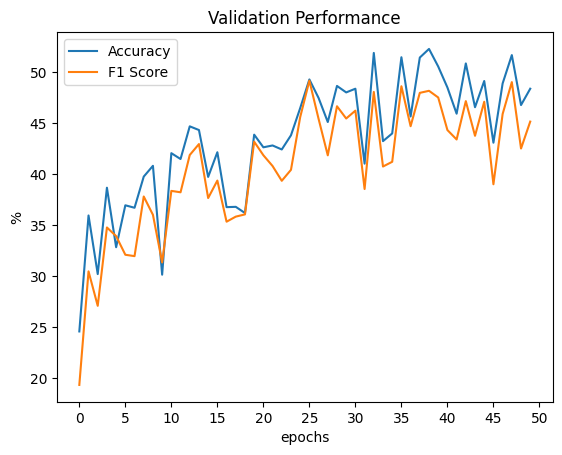

In [128]:
plt.plot(100*np.array(accuracies), label='Accuracy')
plt.plot(100*np.array(f1_scores), label='F1 Score')
plt.title("Validation Performance")
plt.xlabel("epochs")
plt.ylabel("%")
plt.xticks(5*np.array(range(11)))
plt.legend()

print(f"Test Accuracy: {test_accuracy * 100:.2f} %")
print(f"Test F1 Score: {test_f1 * 100:.2f} %")

In [129]:
#Save the model
torch.save(lc.state_dict(), "./lc.pt")

### Define the CV model

In [131]:
class CNNClassifier(nn.Module):
    def __init__(
        self, 
        n_channels=[32,64,128], 
        kernel_sizes=[5,3,3], 
        hidden=64, 
        stride=1, 
        padding=0,
        input_size = [3,256],
        n_classes = 38
    ):
        super(CNNClassifier, self).__init__()

        #IN: 256*256*3 = 196608
        #OUT: (256-kernel_s.models..models.izes[0]+2*padding)/stride + 1
        #EX: (256-6+2*0)/1 + 1 = 251
        self.conv1 = nn.Conv2d(
            in_channels=3,
            out_channels=n_channels[0],
            kernel_size=kernel_sizes[0],
            stride=stride,
            padding=padding
        )

        out_size_conv1 = math.floor(
            (input_size[1] - kernel_sizes[0] + 2*padding)/stride + 1
        )
        #POOLING: floor(251/2) = 125
        out_size_pool1 = math.floor(out_size_conv1/2)

        #IN: 125*125*n_channels[0]
        #EX: 125*125*64 = 1000000
        #OUT: (125-kernel_sizes[1]+2*padding)/stride + 1
        #EX: (125-6+2*0)/1 + 1 = 120
        self.conv2 = nn.Conv2d(
            in_channels=n_channels[0],
            out_channels=n_channels[1],
            kernel_size=kernel_sizes[1],
            stride=stride,
            padding=padding
        )

        out_size_conv2 = math.floor(
            (out_size_pool1 - kernel_sizes[1] + 2*padding)/stride + 1
        )
        #POOLING: floor(120/2) = 60
        out_size_pool2 = math.floor(out_size_conv2/2)

        #IN: 60*60*n_channels[1]
        #EX: 60*60*128 = 460800
        #OUT: (60-kernel_sizes[2]+2*padding)/stride + 1
        #EX: (60-6+2*0)/1 + 1 = 55
        self.conv3 = nn.Conv2d(
            in_channels=n_channels[1],
            out_channels=n_channels[2],
            kernel_size=kernel_sizes[2],
            stride=stride,
            padding=padding
        )

        out_size_conv3 = math.floor(
            (out_size_pool2 - kernel_sizes[2] + 2*padding)/stride + 1
        )

        out_size_pool3 = math.floor(out_size_conv3/2)

        self.pool = nn.MaxPool2d(
            kernel_size=2
        )

        #IN: 55*55*n_channels[2]
        #EX: 774400
        self.lin1 = nn.Linear(out_size_pool3*out_size_pool3*n_channels[2],hidden)
        self.lin2 = nn.Linear(hidden,n_classes)

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.2)
        

    def forward(self,x):
        z = self.conv1(x)
        z = self.relu(z)
        z = self.pool(z)

        z = self.conv2(z)
        z = self.relu(z)
        z = self.pool(z)

        z = self.conv3(z)
        z = self.relu(z)
        z = self.pool(z)

        z = z.view(z.size(0),-1)
        z = self.relu(self.lin1(z))
        z = self.dropout(z)
        z = self.lin2(z)
        return z

In [132]:
torch.cuda.empty_cache()
cnn = CNNClassifier()
batch_size = 32
summary(cnn,input_size=(batch_size,3,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNClassifier                            [32, 38]                  --
├─Conv2d: 1-1                            [32, 32, 252, 252]        2,432
├─ReLU: 1-2                              [32, 32, 252, 252]        --
├─MaxPool2d: 1-3                         [32, 32, 126, 126]        --
├─Conv2d: 1-4                            [32, 64, 124, 124]        18,496
├─ReLU: 1-5                              [32, 64, 124, 124]        --
├─MaxPool2d: 1-6                         [32, 64, 62, 62]          --
├─Conv2d: 1-7                            [32, 128, 60, 60]         73,856
├─ReLU: 1-8                              [32, 128, 60, 60]         --
├─MaxPool2d: 1-9                         [32, 128, 30, 30]         --
├─Linear: 1-10                           [32, 64]                  7,372,864
├─ReLU: 1-11                             [32, 64]                  --
├─Dropout: 1-12                          [32, 64]                  

### Define training process

In [133]:
def train_cnn_model(
    cnn, 
    n_epochs,
    train_loader,
    val_loader,
    optimizer,
    criterion
):
    accuracies = []
    f1_scores = []
    
    for epoch in tqdm(range(n_epochs)):
        #training
        for x_train,y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)
            
            optimizer.zero_grad()
            z = cnn(x_train)
            loss = criterion(z,y_train)
            loss.backward()
            optimizer.step()

        all_labels = []
        all_preds = []
        correct = 0
        #evaluation
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                z_val = cnn(x_val)
                _,y_pred = torch.max(z_val.data,1)
                correct += (y_pred == y_val).sum().item()
                all_labels.extend(y_val.cpu().numpy())
                all_preds.extend(y_pred.cpu().numpy())
                

        accuracy = correct/len(val_loader.dataset)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        print(f"Val Acc: {accuracy * 100:.2f}%, Val F1: {f1 * 100:.2f}%")
        accuracies.append(accuracy)
        f1_scores.append(f1)   

    return accuracies, f1_scores

In [135]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

accuracies, f1_scores = train_cnn_model(cnn,50,train_loader,val_loader,optimizer,criterion)

  2%|▉                                           | 1/50 [01:07<55:18, 67.72s/it]

Val Acc: 36.10%, Val F1: 33.03%


  4%|█▊                                          | 2/50 [02:14<53:54, 67.39s/it]

Val Acc: 45.58%, Val F1: 43.59%


  6%|██▋                                         | 3/50 [03:23<53:18, 68.06s/it]

Val Acc: 52.94%, Val F1: 51.58%


  8%|███▌                                        | 4/50 [04:30<51:54, 67.71s/it]

Val Acc: 56.96%, Val F1: 55.64%


 10%|████▍                                       | 5/50 [05:39<50:57, 67.95s/it]

Val Acc: 60.55%, Val F1: 59.48%


 12%|█████▎                                      | 6/50 [06:47<49:56, 68.10s/it]

Val Acc: 61.52%, Val F1: 60.65%


 14%|██████▏                                     | 7/50 [07:55<48:47, 68.09s/it]

Val Acc: 65.98%, Val F1: 65.13%


 16%|███████                                     | 8/50 [09:04<47:47, 68.26s/it]

Val Acc: 66.71%, Val F1: 66.22%


 18%|███████▉                                    | 9/50 [10:15<47:20, 69.29s/it]

Val Acc: 67.31%, Val F1: 66.61%


 20%|████████▌                                  | 10/50 [11:24<46:02, 69.06s/it]

Val Acc: 68.91%, Val F1: 68.37%


 22%|█████████▍                                 | 11/50 [12:33<44:50, 68.98s/it]

Val Acc: 69.88%, Val F1: 69.48%


 24%|██████████▎                                | 12/50 [13:43<43:59, 69.45s/it]

Val Acc: 70.03%, Val F1: 69.79%


 26%|███████████▏                               | 13/50 [14:52<42:35, 69.08s/it]

Val Acc: 71.51%, Val F1: 71.14%


 28%|████████████                               | 14/50 [15:59<41:11, 68.65s/it]

Val Acc: 71.57%, Val F1: 71.20%


 30%|████████████▉                              | 15/50 [17:07<39:55, 68.46s/it]

Val Acc: 72.20%, Val F1: 71.96%


 32%|█████████████▊                             | 16/50 [18:15<38:39, 68.22s/it]

Val Acc: 71.60%, Val F1: 71.18%


 34%|██████████████▌                            | 17/50 [19:24<37:39, 68.45s/it]

Val Acc: 71.72%, Val F1: 71.61%


 36%|███████████████▍                           | 18/50 [20:32<36:24, 68.27s/it]

Val Acc: 72.08%, Val F1: 71.93%


 38%|████████████████▎                          | 19/50 [21:40<35:20, 68.40s/it]

Val Acc: 71.69%, Val F1: 71.52%


 40%|█████████████████▏                         | 20/50 [22:49<34:13, 68.44s/it]

Val Acc: 72.65%, Val F1: 72.40%


 42%|██████████████████                         | 21/50 [23:57<33:02, 68.36s/it]

Val Acc: 73.26%, Val F1: 73.27%


 44%|██████████████████▉                        | 22/50 [25:05<31:49, 68.19s/it]

Val Acc: 74.25%, Val F1: 74.12%


 46%|███████████████████▊                       | 23/50 [26:13<30:40, 68.16s/it]

Val Acc: 73.77%, Val F1: 73.41%


 48%|████████████████████▋                      | 24/50 [27:21<29:30, 68.08s/it]

Val Acc: 73.98%, Val F1: 73.84%


 50%|█████████████████████▌                     | 25/50 [28:29<28:20, 68.04s/it]

Val Acc: 72.38%, Val F1: 72.27%


 52%|██████████████████████▎                    | 26/50 [29:37<27:15, 68.13s/it]

Val Acc: 74.16%, Val F1: 74.09%


 54%|███████████████████████▏                   | 27/50 [30:45<26:06, 68.12s/it]

Val Acc: 73.92%, Val F1: 73.75%


 56%|████████████████████████                   | 28/50 [31:55<25:11, 68.71s/it]

Val Acc: 74.92%, Val F1: 74.59%


 58%|████████████████████████▉                  | 29/50 [33:04<24:04, 68.81s/it]

Val Acc: 73.92%, Val F1: 73.68%


 60%|█████████████████████████▊                 | 30/50 [34:13<22:57, 68.87s/it]

Val Acc: 73.35%, Val F1: 73.30%


 62%|██████████████████████████▋                | 31/50 [35:22<21:44, 68.66s/it]

Val Acc: 75.19%, Val F1: 75.02%


 64%|███████████████████████████▌               | 32/50 [36:29<20:30, 68.35s/it]

Val Acc: 73.14%, Val F1: 73.25%


 66%|████████████████████████████▍              | 33/50 [37:38<19:22, 68.41s/it]

Val Acc: 75.43%, Val F1: 75.27%


 68%|█████████████████████████████▏             | 34/50 [38:45<18:11, 68.20s/it]

Val Acc: 73.89%, Val F1: 73.77%


 70%|██████████████████████████████             | 35/50 [39:54<17:05, 68.40s/it]

Val Acc: 75.07%, Val F1: 74.93%


 72%|██████████████████████████████▉            | 36/50 [41:02<15:54, 68.19s/it]

Val Acc: 74.46%, Val F1: 74.45%


 74%|███████████████████████████████▊           | 37/50 [42:10<14:45, 68.15s/it]

Val Acc: 74.65%, Val F1: 74.49%


 76%|████████████████████████████████▋          | 38/50 [43:18<13:36, 68.02s/it]

Val Acc: 74.10%, Val F1: 74.21%


 78%|█████████████████████████████████▌         | 39/50 [44:26<12:28, 68.03s/it]

Val Acc: 73.26%, Val F1: 73.10%


 80%|██████████████████████████████████▍        | 40/50 [45:33<11:19, 67.91s/it]

Val Acc: 75.10%, Val F1: 75.03%


 82%|███████████████████████████████████▎       | 41/50 [46:41<10:10, 67.86s/it]

Val Acc: 74.37%, Val F1: 74.59%


 84%|████████████████████████████████████       | 42/50 [47:49<09:03, 67.91s/it]

Val Acc: 74.98%, Val F1: 74.99%


 86%|████████████████████████████████████▉      | 43/50 [48:57<07:55, 67.91s/it]

Val Acc: 74.19%, Val F1: 74.01%


 88%|█████████████████████████████████████▊     | 44/50 [50:05<06:46, 67.79s/it]

Val Acc: 74.52%, Val F1: 74.70%


 90%|██████████████████████████████████████▋    | 45/50 [51:12<05:38, 67.76s/it]

Val Acc: 74.86%, Val F1: 74.65%


 92%|███████████████████████████████████████▌   | 46/50 [52:20<04:30, 67.69s/it]

Val Acc: 75.31%, Val F1: 75.34%


 94%|████████████████████████████████████████▍  | 47/50 [53:28<03:23, 67.79s/it]

Val Acc: 75.49%, Val F1: 75.39%


 96%|█████████████████████████████████████████▎ | 48/50 [54:35<02:15, 67.71s/it]

Val Acc: 73.80%, Val F1: 73.69%


 98%|██████████████████████████████████████████▏| 49/50 [55:44<01:07, 67.84s/it]

Val Acc: 75.22%, Val F1: 75.02%


100%|███████████████████████████████████████████| 50/50 [56:52<00:00, 68.25s/it]

Val Acc: 73.65%, Val F1: 73.52%


In [136]:
def evaluate_cnn_model(
    cnn,
    test_loader
):
    correct = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
                
            z_test = cnn(x_test)
            _,y_pred = torch.max(z_test.data,1)
            correct += (y_pred == y_test).sum().item()
            all_labels.extend(y_test.cpu().numpy())
            all_preds.extend(y_pred.cpu().numpy())

    accuracy = correct/len(test_loader.dataset)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return accuracy, f1

In [137]:
test_accuracy, test_f1 = evaluate_cnn_model(cnn,test_loader)

Test Accuracy: 72.51 %
Test F1 Score: 72.42 %


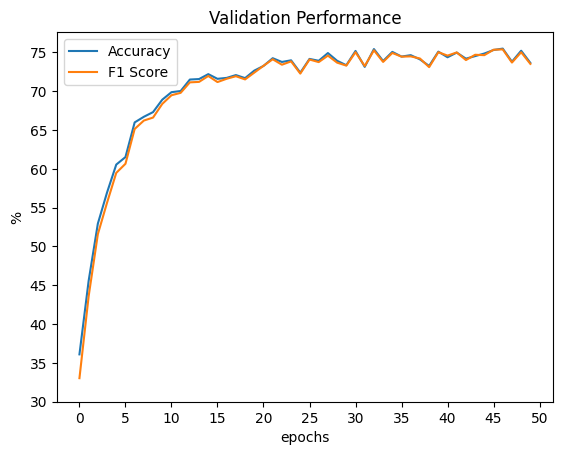

In [141]:
plt.plot(100*np.array(accuracies), label='Accuracy')
plt.plot(100*np.array(f1_scores), label='F1 Score')
plt.title("Validation Performance")
plt.xlabel("epochs")
plt.ylabel("%")
plt.xticks(5*np.array(range(11)))
plt.yticks(5*np.array(range(10))+30)
plt.legend()

print(f"Test Accuracy: {test_accuracy * 100:.2f} %")
print(f"Test F1 Score: {test_f1 * 100:.2f} %")

In [142]:
#Save the model
torch.save(cnn.state_dict(), "./cnn.pt")

### Define transfer learning model

In [143]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16)

In [144]:
efi_net = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
dict(efi_net.classifier.named_modules())

{'': Sequential(
   (0): Dropout(p=0.2, inplace=True)
   (1): Linear(in_features=1280, out_features=1000, bias=True)
 ),
 '0': Dropout(p=0.2, inplace=True),
 '1': Linear(in_features=1280, out_features=1000, bias=True)}

In [145]:
input_features = efi_net.classifier[1].in_features
n_classes = 38
efi_net.classifier[1] = nn.Linear(in_features=input_features, out_features=n_classes, bias=True)
dict(efi_net.classifier.named_modules())

{'': Sequential(
   (0): Dropout(p=0.2, inplace=True)
   (1): Linear(in_features=1280, out_features=38, bias=True)
 ),
 '0': Dropout(p=0.2, inplace=True),
 '1': Linear(in_features=1280, out_features=38, bias=True)}

In [146]:
torch.cuda.empty_cache()
learning_rate = 1e-3
optimizer = torch.optim.Adam(efi_net.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
efi_net.to(device)
accuracies, f1_scores = train_cnn_model(efi_net,10,train_loader,val_loader,optimizer,criterion)

  0%|                                                    | 0/10 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 3.80 GiB of which 20.12 MiB is free. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.27 GiB is allocated by PyTorch, and 23.86 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
test_accuracy, test_f1 = evaluate_cnn_model(efi_net,test_loader)

Test Accuracy: 0.976161738080869


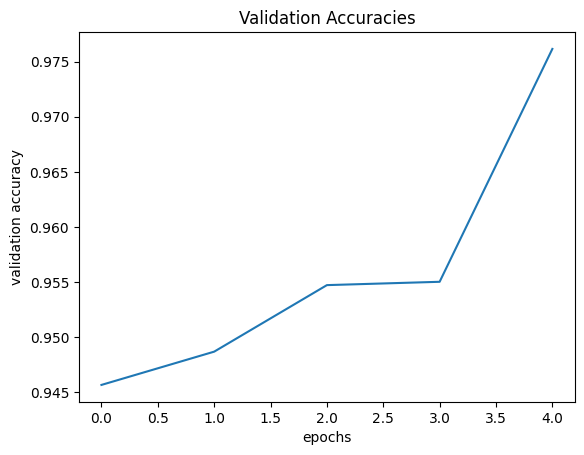

In [13]:
plt.plot(accuracies)
plt.title("Validation Accuracies")
plt.xlabel("epochs")
plt.ylabel("validation accuracy")

print("Test Accuracy: " + str(test_accuracy))
print("Test F1 Score: " + str(test_f1))

In [ ]:
#Save the model
torch.save(efi_net.state_dict(), "./efi.pt")